In [140]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [141]:
df = pd.read_csv("AmesHousing.csv")
features_to_keep = ['Bsmt Half Bath','Bsmt Full Bath','Total Bsmt SF','Lot Area','Lot Shape','House Style','Neighborhood', 'Gr Liv Area',
                    'Year Built','Bsmt Cond','Central Air','Overall Cond','Full Bath','TotRms AbvGrd','Fireplaces','Garage Area','Yr Sold','Kitchen Qual','SalePrice']
df = df[features_to_keep]

# Checking to see which features have null values
df.isnull().sum()

Bsmt Half Bath     2
Bsmt Full Bath     2
Total Bsmt SF      1
Lot Area           0
Lot Shape          0
House Style        0
Neighborhood       0
Gr Liv Area        0
Year Built         0
Bsmt Cond         80
Central Air        0
Overall Cond       0
Full Bath          0
TotRms AbvGrd      0
Fireplaces         0
Garage Area        1
Yr Sold            0
Kitchen Qual       0
SalePrice          0
dtype: int64

In [142]:
# Checking the type of data in each column. We notice we have five categorical features and the rest are numerical
df.dtypes

Bsmt Half Bath    float64
Bsmt Full Bath    float64
Total Bsmt SF     float64
Lot Area            int64
Lot Shape          object
House Style        object
Neighborhood       object
Gr Liv Area         int64
Year Built          int64
Bsmt Cond          object
Central Air        object
Overall Cond        int64
Full Bath           int64
TotRms AbvGrd       int64
Fireplaces          int64
Garage Area       float64
Yr Sold             int64
Kitchen Qual       object
SalePrice           int64
dtype: object

In [143]:
# Here, we now fill the missing features
df["Bsmt Cond"] = df["Bsmt Cond"].fillna("None") # Most likely they are null since the house does not have a basement

# Fill numerical basement/garage features with 0
fill_zero_cols = ["Garage Area", "Total Bsmt SF", "Bsmt Full Bath", "Bsmt Half Bath"] # Most likely they are null since the house does not have a basement/garage
df[fill_zero_cols] = df[fill_zero_cols].fillna(0)

In [144]:
# Separate features and target
X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# splitting columns into categorical and numerical so we can scale numeric features and encode categorical features
categorical_cols = ["Lot Shape", "House Style", "Neighborhood", "Central Air"]
ordinal_cols = ["Bsmt Cond","Kitchen Qual"]
numerical_cols = [col for col in X.columns if col not in (categorical_cols + ordinal_cols)]

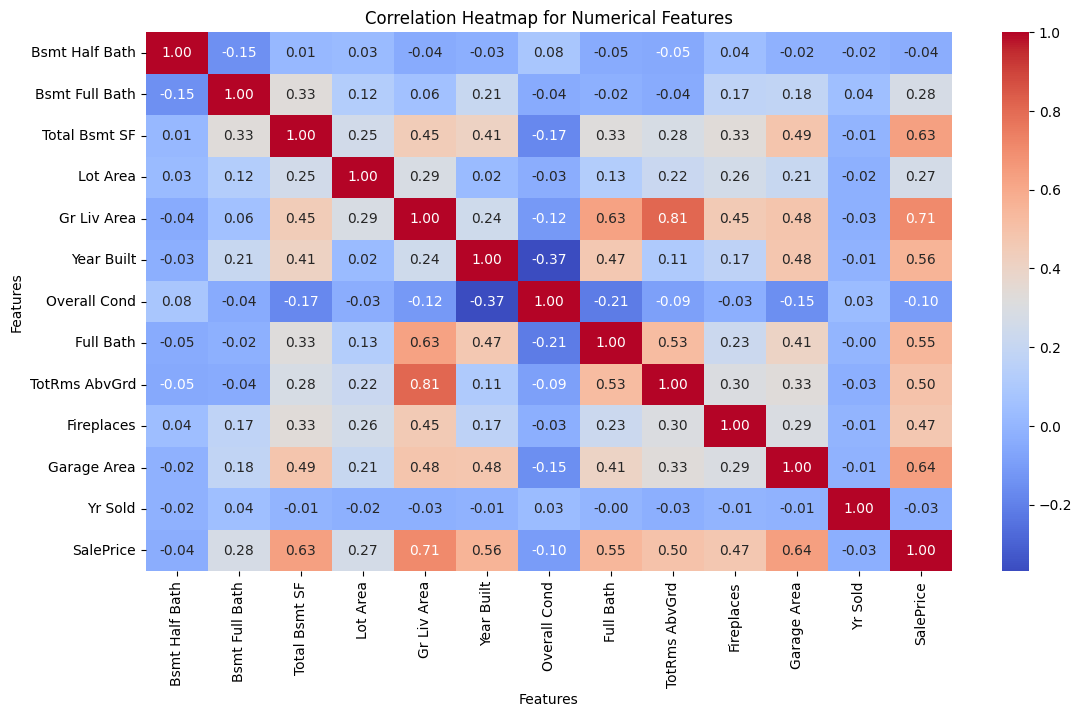

In [145]:
# We want to visualize the correlation matrix between numerical features. We first create a dataframe made up of numerical features and then plot the correlation matrix.

numerical_df = df.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(13,7))
sns.heatmap(correlation_matrix,annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.xlabel("Features")
plt.ylabel("Features")
plt.title("Correlation Heatmap for Numerical Features")
plt.show()


## Preprocessing the Data and Using Linear Regression

In [146]:
# From the categorical features, the basement condition is the only ordinal one, so it's best that we use the OrdinalEncoder for that feature instead of the OneHotEncoder that we will use for the other features 
ordinal_categories = [
    ['Po', 'None', 'Fa', 'Gd', 'TA', 'Ex'],   # Bsmt Cond
    ['Po', 'Fa', 'Gd', 'TA', 'Ex']            # Kitchen Qual
]

numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('onehot',OneHotEncoder(handle_unknown='ignore'))])
ordinal_transformer = Pipeline([("ordinal",OrdinalEncoder(categories=ordinal_categories))])

preprocessor = ColumnTransformer([("num", numeric_transformer, numerical_cols),
                                  ("cat", categorical_transformer, categorical_cols),("ord", ordinal_transformer, ordinal_cols)])
linear_regression_model = Pipeline([("preprocess", preprocessor),("regressor", LinearRegression())])

# Fit the model
linear_regression_model.fit(X_train,y_train)

y_pred_lr = linear_regression_model.predict(X_test)



# Visualizing the Results

In [147]:
rmse_lr = np.sqrt(mean_squared_error(y_pred_lr, y_test))
mae_lr = mean_absolute_error(y_pred_lr, y_test)
r2_lr = r2_score(y_pred_lr,y_test)
mape_lr = np.mean(np.abs((y_test - y_pred_lr) / y_test)) * 100
results_lr = pd.DataFrame({"Model:": ["Linear Regression"], "RMSE:":[round(rmse_lr,2)], "MAE:":[round(mae_lr,2)], "R2:":[round(r2_lr,2)], "MAPE(%):":[round(mape_lr,2)]})
print(results_lr)

              Model:     RMSE:      MAE:   R2:  MAPE(%):
0  Linear Regression  35961.25  21897.91  0.79     11.79


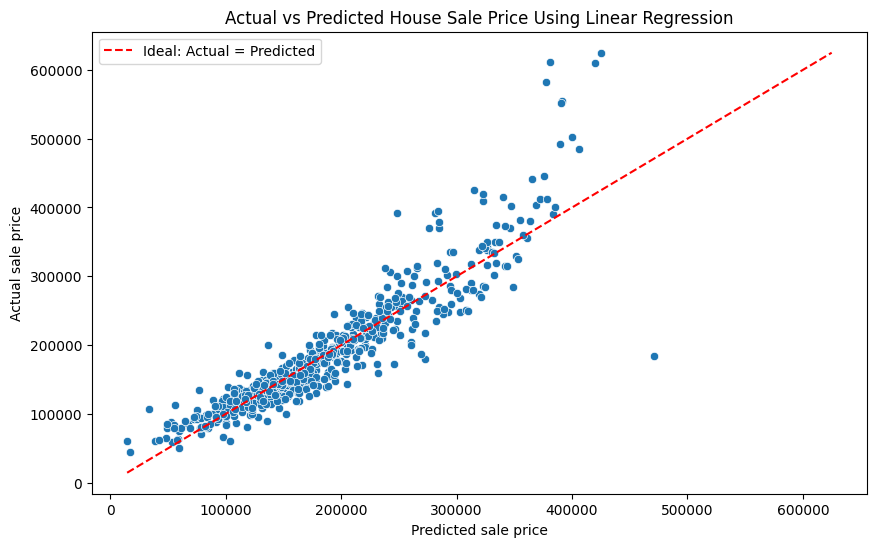

In [148]:
plt.figure(figsize=(10,6))
sns.scatterplot(x= y_pred_lr, y= y_test)
plt.xlabel('Predicted sale price')
plt.ylabel('Actual sale price')
plt.title('Actual vs Predicted House Sale Price Using Linear Regression')

max_val = max(max(y_test), max(y_pred_lr))
min_val = min(min(y_test), min(y_pred_lr))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal: Actual = Predicted')
plt.legend()
plt.show()

## Using Random Forest

# Doing a Grid Search for Best Hyperparameters

In [149]:
# We will now use Random Forest to see how well it does compared to Linear Regression

# we make a grid of different values for the hyperparameters. You can include more options if you'd like
param_grid = {'regressor__n_estimators': [50,100,150,200], 'regressor__max_depth': [None, 5, 10], 'regressor__min_samples_split': [2,5,10], 'regressor__min_samples_leaf': [1,2]}
rf_pipeline = Pipeline([('preproces', preprocessor), ('regressor', RandomForestRegressor(random_state=42))])

grid_search = GridSearchCV(rf_pipeline, param_grid = param_grid, cv =5,scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproces',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Bsmt '
                                                                          'Half '
                                                                          'Bath',
                                                                          'Bsmt '
                                                                          'Full '
                                                                          'Bath',
                                                                          'Total '
                                                                          'Bsmt '
                                                                          'SF',
                                                                          'Lot '
                                                                          'Area',
                                                                          'Gr '
                                                                          'Liv '
                                                                          'Area',
                                                                          'Year '
                                                                          'Built',
                                                                          'Overall '
                                                                          'Cond',
                                                                          'Full '
                                                                          'Bath',
                                                                          'TotRms '
                                                                          'AbvGrd',
                                                                          'Fireplaces',
                                                                          'Garage '
                                                                          'Area',
                                                                          'Yr '
                                                                          'Sold']),
                                                                        ('cat',
                                                                         Pipeline(steps=...
                                                                                                                      'Ex'],
                                                                                                                     ['Po',
                                                                                                                      'Fa',
                                                                                                                      'Gd',
                                                                                                                      'TA',
                                                                                                                      'Ex']]))]),
                                                                         ['Bsmt '
                                                                          'Cond',
                                                                          'Kitchen '
                                                                          'Qual'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jo

In [150]:
# Here are the best parameters it chose from the grid given
print(grid_search.best_params_)

{'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 150}


In [151]:
# We now run it with the best chosen hyperparameters
best_rf_model = grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_pred_rf, y_test))
mae_rf = mean_absolute_error(y_pred_rf, y_test)
r2_score_rf = r2_score(y_pred_rf, y_test)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100
results_rf = pd.DataFrame({"Model:": ["Random Forest"], "RMSE:":[round(rmse_rf,2)], "MAE:":[round(mae_rf,2)], "R2:":[round(r2_score_rf,2)], "MAPE(%):":[round(mape_rf,2)]})
print(results_rf)

          Model:     RMSE:      MAE:   R2:  MAPE(%):
0  Random Forest  29377.44  16784.22  0.87       9.1


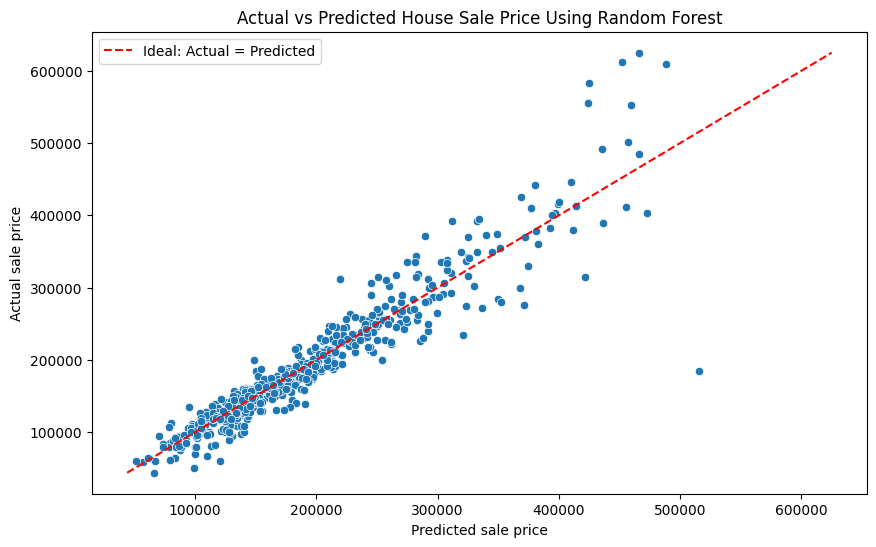

In [152]:
plt.figure(figsize=(10,6))
sns.scatterplot(x= y_pred_rf, y= y_test)
plt.xlabel('Predicted sale price')
plt.ylabel('Actual sale price')
plt.title('Actual vs Predicted House Sale Price Using Random Forest')

max_val = max(max(y_test), max(y_pred_rf))
min_val = min(min(y_test), min(y_pred_rf))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal: Actual = Predicted')
plt.legend()
plt.show()

## Using XGBoost

In [153]:
param_grid_xg = {
    'regressor__n_estimators': [100,200,300,350,400],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01,0.05, 0.1, 0.15],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}
xgboost_pipeline = Pipeline([("preprocessor", preprocessor), ("regressor", XGBRegressor())])

grid_search_xg = GridSearchCV(xgboost_pipeline, param_grid = param_grid_xg, cv =5,scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_xg.fit(X_train,y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Bsmt '
                                                                          'Half '
                                                                          'Bath',
                                                                          'Bsmt '
                                                                          'Full '
                                                                          'Bath',
                                                                          'Total '
                                                                          'Bsmt '
                                                                          'SF',
                                                                          'Lot '
                                                                          'Area',
                                                                          'Gr '
                                                                          'Liv '
                                                                          'Area',
                                                                          'Year '
                                                                          'Built',
                                                                          'Overall '
                                                                          'Cond',
                                                                          'Full '
                                                                          'Bath',
                                                                          'TotRms '
                                                                          'AbvGrd',
                                                                          'Fireplaces',
                                                                          'Garage '
                                                                          'Area',
                                                                          'Yr '
                                                                          'Sold']),
                                                                        ('cat',
                                                                         Pipeline(ste...
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'regressor__colsample_bytree': [0.8, 1.0],
                         'regressor__learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'regressor__max_depth': [3, 5, 7],
                         'regressor__n_estimators': [100, 200, 300, 350, 400],
                         'regressor__subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [154]:
print(grid_search_xg.best_params_)

{'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 400, 'regressor__subsample': 1.0}


In [155]:
# We now run it with the best chosen hyperparameters
best_xg_model = grid_search_xg.best_estimator_
y_pred_xg = best_xg_model.predict(X_test)
rmse_xg = np.sqrt(mean_squared_error(y_pred_xg, y_test))
mae_xg = mean_absolute_error(y_pred_xg, y_test)
r2_score_xg = r2_score(y_pred_xg, y_test)
mape_xg = np.mean(np.abs((y_test - y_pred_xg) / y_test)) * 100
results_xg = pd.DataFrame({"Model:": ["Random Forest"], "RMSE:":[round(rmse_xg,2)], "MAE:":[round(mae_xg,2)], "R2:":[round(r2_score_xg,2)], "MAPE(%):":[round(mape_xg,2)]})
print(results_xg)

          Model:     RMSE:      MAE:  R2:  MAPE(%):
0  Random Forest  26585.83  16032.19  0.9      8.61


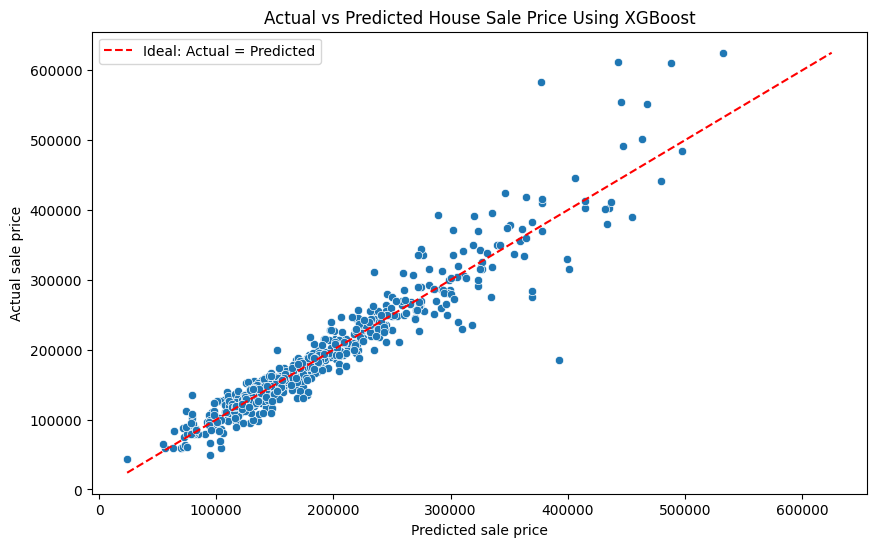

In [156]:
plt.figure(figsize=(10,6))
sns.scatterplot(x= y_pred_xg, y= y_test)
plt.xlabel('Predicted sale price')
plt.ylabel('Actual sale price')
plt.title('Actual vs Predicted House Sale Price Using XGBoost')

max_val = max(max(y_test), max(y_pred_xg))
min_val = min(min(y_test), min(y_pred_xg))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal: Actual = Predicted')
plt.legend()
plt.show()

## Building a Neural Network Using Pytorch

In [ ]:

# Preprocess features
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# If sparse, convert to dense
if hasattr(X_train_processed, "toarray"):
    X_train_processed = X_train_processed.toarray()
    X_test_processed = X_test_processed.toarray()

# Scale target
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.to_numpy().reshape(-1, 1))

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using GPU
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



hidden_layers = [
    [32],
    [64, 32],
    [128, 64],
]

class HousePriceNN(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super().__init__()
        layers = []
        current_dim = input_dim

        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            current_dim = hidden_dim

        layers.append(nn.Linear(current_dim, 1))  # Output layer
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

results_nn = []

for arch in hidden_layers:
    set_seed(42)
    print(f"\nTraining architecture: {arch}")
    model = HousePriceNN(input_dim=X_train_tensor.shape[1], hidden_layers=arch)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    epochs = 200
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor).numpy()
        y_pred_actual = y_scaler.inverse_transform(y_pred_scaled)
        y_test_actual = y_test.values.reshape(-1, 1)

        rmse_nn = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
        r2_nn = r2_score(y_test_actual, y_pred_actual)
        mape_nn = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
        mae_nn = mean_absolute_error(y_test_actual,y_pred_actual)

        results_nn.append({"architecture": arch, "RMSE": rmse_nn, "R²": r2_nn, "MAE": mae_nn, "MAPE (%)": mape_nn})
import pandas as pd
df_results_nn = pd.DataFrame(results_nn)
print(df_results_nn.sort_values(by="RMSE"))



Training architecture: [32]

Training architecture: [64, 32]

Training architecture: [128, 64]
  architecture          RMSE        R²           MAE  MAPE (%)
1     [64, 32]  23928.337009  0.928586  15694.333984  8.563932
2    [128, 64]  24278.373586  0.926481  15821.776367  8.788225
0         [32]  26227.977734  0.914200  16378.550781  8.698722


In [165]:
set_seed(42)
best_architecture = [64, 32]

model_nn = HousePriceNN(input_dim=X_train_tensor.shape[1], hidden_layers=best_architecture)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model_nn.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model_nn(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

model_nn.eval()
with torch.no_grad():
    y_pred_scaled = model_nn(X_test_tensor).numpy()
    y_pred_actual = y_scaler.inverse_transform(y_pred_scaled)
    y_test_actual = y_test.values.reshape(-1, 1)

from sklearn.metrics import mean_squared_error, r2_score

rmse_nn = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2_nn = r2_score(y_test_actual, y_pred_actual)
mape_nn = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
mae_nn = mean_absolute_error(y_test_actual,y_pred_actual)


print(f"Final Model [64, 32] → RMSE: {rmse_nn:,.2f}, R²: {r2_nn:.4f}, MAE: {mae_nn:.2f}, MAPE (%): {mape_nn:.2f}")


Final Model [64, 32] → RMSE: 23,928.34, R²: 0.9286, MAE: 15694.33, MAPE (%): 8.56


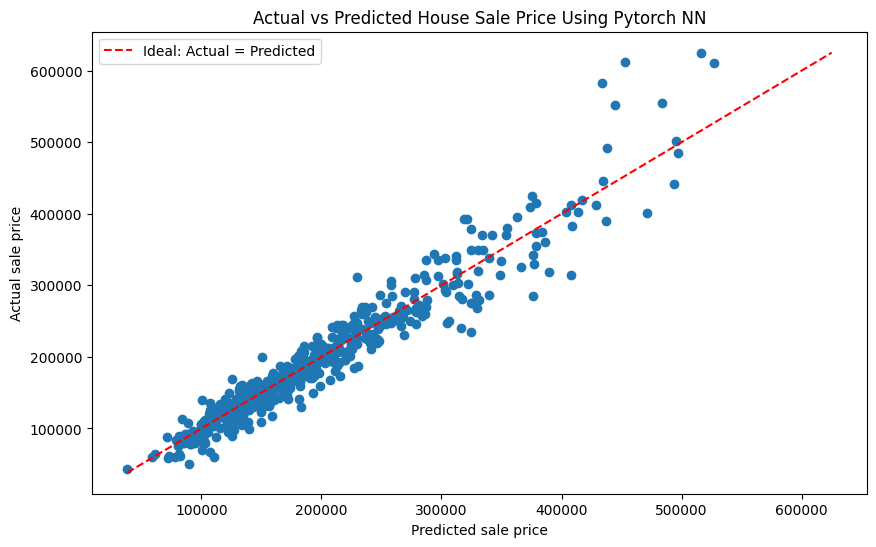

In [166]:
plt.figure(figsize=(10,6))
plt.scatter(x= y_pred_actual, y= y_test_actual)
plt.xlabel('Predicted sale price')
plt.ylabel('Actual sale price')
plt.title('Actual vs Predicted House Sale Price Using Pytorch NN')

max_val = max(max(y_test_actual), max(y_pred_actual))
min_val = min(min(y_test_actual), min(y_pred_actual))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal: Actual = Predicted')
plt.legend()
plt.show()